In [1]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torch.utils.data import DataLoader
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
seed = 47
random.seed(seed)
torch.manual_seed(seed)

In [3]:
device = torch.device('cpu') if not torch.cuda.is_available() else torch.device("cuda")

In [4]:
cifar = CIFAR10(root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))

Files already downloaded and verified


In [5]:
print(*cifar.classes)

airplane automobile bird cat deer dog frog horse ship truck


In [6]:
ix = (np.array(cifar.targets) == cifar.class_to_idx["dog"]) | (np.array(cifar.targets) == cifar.class_to_idx["horse"])

In [7]:
cifar.data = cifar.data[ix]
cifar.targets = np.array(cifar.targets)[ix]

In [8]:
cifar.data.shape, cifar.targets.shape

((10000, 32, 32, 3), (10000,))

In [9]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, 4, 2, 1),
            nn.Sigmoid(),
        )

    def forward(self, X):
        return self.network(X)
    

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(3, 128, 5),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 3, 2, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 3, 2, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(512*6*6, 1),
            nn.Sigmoid()
        )

    def forward(self, X):
        return self.network(X)

In [10]:
criterion = nn.BCELoss()
nz = 100
fixed_noise = torch.randn(128, nz, 1, 1, device=device)

gen = Generator(nz)
gen.to(device)
dis = Discriminator()
dis.to(device)


optimizerD = torch.optim.Adam(dis.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))

writer = SummaryWriter("./runs/exp3")

dataloader = DataLoader(cifar, batch_size=128, shuffle=True)
n_epochs = 250
k = 1

In [11]:
for epoch in range(n_epochs):
    print(f"Epoch: [{epoch+1}/{n_epochs}]")
    for i, (x, y) in enumerate(dataloader, 1):
        
        optimizerD.zero_grad()
        
        real_x = x.to(device)
        
        b_size = real_x.size(0)
        label = torch.full((b_size,1), 1, dtype=torch.float, device=device)
        
        output = dis(real_x)
        err_real_D = criterion(output, label)
        err_real_D.backward()
        
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_x = gen(noise)
        label.fill_(0)
        output = dis(fake_x.detach())
        err_fake_D = criterion(output, label)
        err_fake_D.backward()
        
        err_D = err_real_D + err_fake_D
        optimizerD.step()
        
        optimizerG.zero_grad()
        
        label.fill_(1)
        for j in range(k):
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            fake_x = gen(noise)
            output = dis(fake_x)
            err_G = criterion(output, label)
            err_G.backward()

            optimizerG.step()
        
        if i%10 == 0:
            print("\rStep: [%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f"%(i, len(dataloader), err_D.item(), err_G.item()), end="")
            writer.add_scalar('Loss/Discriminator', err_D.item(), epoch*len(dataloader)+i)
            writer.add_scalar('Loss/Generator', err_G.item(), epoch*len(dataloader)+i)
            
            if i%30 == 0:
                
                with torch.no_grad():
                    fake_imgs = gen(fixed_noise).detach().cpu()
                
                grid = torchvision.utils.make_grid(fake_imgs)
                writer.add_image('Generated Image', grid, epoch*len(dataloader)+i)
                
                if epoch == 0:
                    grid = torchvision.utils.make_grid(real_x)
                    writer.add_image('Real Image', grid, epoch*len(dataloader)+i)

    print()
    
    torch.save(gen.state_dict(), "./generator-f1.pth")
    torch.save(dis.state_dict(), "./discriminator-f1.pth")
    writer.close()

Epoch: [1/250]
Step: [70/79]	Loss_D: 0.8320	Loss_G: 7.3364
Epoch: [2/250]
Step: [70/79]	Loss_D: 0.6517	Loss_G: 8.98410
Epoch: [3/250]
Step: [70/79]	Loss_D: 0.3632	Loss_G: 4.4942
Epoch: [4/250]
Step: [70/79]	Loss_D: 0.3383	Loss_G: 5.1644
Epoch: [5/250]
Step: [70/79]	Loss_D: 0.1584	Loss_G: 5.1486
Epoch: [6/250]
Step: [70/79]	Loss_D: 1.0528	Loss_G: 10.5431
Epoch: [7/250]
Step: [70/79]	Loss_D: 0.4213	Loss_G: 6.1313
Epoch: [8/250]
Step: [70/79]	Loss_D: 0.2107	Loss_G: 5.4800
Epoch: [9/250]
Step: [70/79]	Loss_D: 0.2005	Loss_G: 8.0016
Epoch: [10/250]
Step: [70/79]	Loss_D: 0.0773	Loss_G: 4.6832
Epoch: [11/250]
Step: [70/79]	Loss_D: 0.3613	Loss_G: 6.6790
Epoch: [12/250]
Step: [70/79]	Loss_D: 0.2000	Loss_G: 5.3960
Epoch: [13/250]
Step: [70/79]	Loss_D: 0.2436	Loss_G: 6.0025
Epoch: [14/250]
Step: [70/79]	Loss_D: 0.4883	Loss_G: 6.8391
Epoch: [15/250]
Step: [70/79]	Loss_D: 0.2650	Loss_G: 5.0801
Epoch: [16/250]
Step: [70/79]	Loss_D: 0.8168	Loss_G: 3.1185
Epoch: [17/250]
Step: [70/79]	Loss_D: 0.7862	Lo

Step: [70/79]	Loss_D: 0.0907	Loss_G: 3.9978
Epoch: [138/250]
Step: [70/79]	Loss_D: 0.1077	Loss_G: 4.1477
Epoch: [139/250]
Step: [70/79]	Loss_D: 0.1437	Loss_G: 3.2669
Epoch: [140/250]
Step: [70/79]	Loss_D: 0.1170	Loss_G: 4.1027
Epoch: [141/250]
Step: [70/79]	Loss_D: 0.0812	Loss_G: 3.9901
Epoch: [142/250]
Step: [70/79]	Loss_D: 0.3521	Loss_G: 4.3907
Epoch: [143/250]
Step: [70/79]	Loss_D: 0.2648	Loss_G: 3.4093
Epoch: [144/250]
Step: [70/79]	Loss_D: 0.5450	Loss_G: 3.2608
Epoch: [145/250]
Step: [70/79]	Loss_D: 0.0790	Loss_G: 4.9294
Epoch: [146/250]
Step: [70/79]	Loss_D: 0.0489	Loss_G: 6.0716
Epoch: [147/250]
Step: [70/79]	Loss_D: 0.3408	Loss_G: 3.8753
Epoch: [148/250]
Step: [70/79]	Loss_D: 0.2148	Loss_G: 4.3808
Epoch: [149/250]
Step: [70/79]	Loss_D: 0.2745	Loss_G: 5.3814
Epoch: [150/250]
Step: [70/79]	Loss_D: 0.1016	Loss_G: 3.8394
Epoch: [151/250]
Step: [70/79]	Loss_D: 0.2392	Loss_G: 4.9322
Epoch: [152/250]
Step: [70/79]	Loss_D: 0.1929	Loss_G: 3.6284
Epoch: [153/250]
Step: [70/79]	Loss_D: 0.

## Model Eval

In [16]:
gen.eval()

Generator(
  (network): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (10): Sigmoid()
  )
)

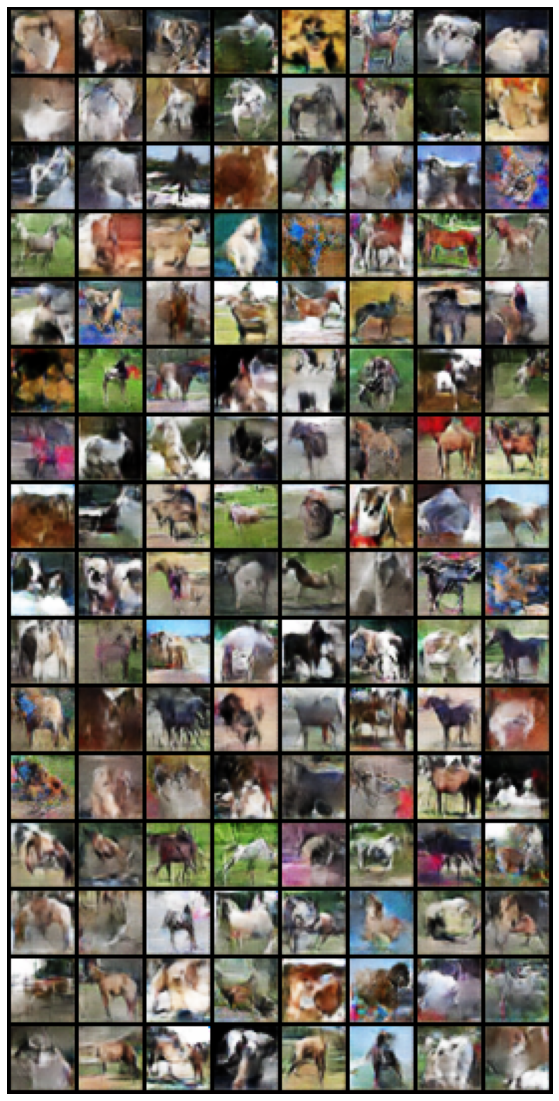

In [33]:
gen_imgs = gen(torch.randn(128, 100, 1, 1, device=device))
grid = torchvision.utils.make_grid(gen_imgs)

img_arr = grid.detach().cpu().numpy()

plt.figure(figsize=(10, 20))
plt.imshow(np.transpose(img_arr, (1, 2, 0)))
plt.axis("off")
plt.show()